In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [33]:
data = pd.read_csv("breast_cancer.csv")

In [34]:
data.head()

,Unnamed: 0,id number,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,0,1000025,5,1,1,1,2,1,3,1,1,0
1,1,1002945,5,4,4,5,7,10,3,2,1,0
2,2,1015425,3,1,1,1,2,2,3,1,1,0
3,3,1016277,6,8,8,1,3,4,3,7,1,0
4,4,1017023,4,1,1,3,2,1,3,1,1,0


In [35]:
#lets drop column unnamed:0 and id number
data = data.drop(['Unnamed: 0', 'id number'], axis=1)

In [36]:
#We would like to predict malignant 
y = data.pop("malignant")

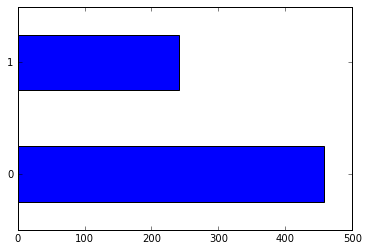

In [74]:
#lets understand our dependent variable 
y.value_counts().plot(kind='barh')

In [37]:
#Lets split the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)

In [40]:
### Grid Search
n_estimators = [300,400,500]
max_features = ['auto', 'sqrt','log2']
min_samples_split = [3,5,7,9]


rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

In [41]:
#lets fit the model with training set
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [3, 5, 7, 9], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [42]:
#lets check the best estimator 
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)



From the results we can see that the best estimator is when max_features at sqrt , min_samples_split of 3 and 300 n_estimators 


In [47]:
#Assign best estimator
best_rfc = estimator.best_estimator_

In [48]:
#lets check the acuracy 
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.971428571429


In [49]:
#lets understand Precision and Recall from the classification report
print classification_report(y_test, best_rfc.predict(X_test))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98        95
          1       0.96      0.96      0.96        45

avg / total       0.97      0.97      0.97       140



Precision : The model correctly identifies 96% of the malignant tumors but there is a 4% chance that the model will not identify malignant tumor

Recall: In the total malignant tumors predicted 96% will actaully be malignant


In [50]:
#Lets try to plot a confusion matrix and understand precision and recall 
print confusion_matrix(y_test, best_rfc.predict(X_test))

[[93  2]
 [ 2 43]]


The true negative here is 43 and false postive is 2    
False negative is 2 and true postive is 43 

precision = tp/(tp+fp)                     
Precision: 43 / 43 + 2 = .96

Recall = (tp / tp + fn)    
Recall: 43 / 43 + 2 = .96

In [51]:
#lets check the AUC for the model
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print "AUC Score: ", roc

AUC Score:  0.99649122807


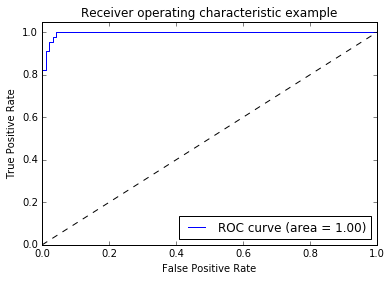

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [64]:
#lets Implement K-Fold Cross Validation, with 10 folds
from sklearn import cross_validation
scores = cross_validation.cross_val_score(best_rfc, data, y, cv=10)

In [65]:
scores

array([ 0.91549296,  0.95714286,  0.97142857,  0.91428571,  0.98571429,
        0.98571429,  0.97142857,  0.98571429,  0.98550725,  1.        ])

In [66]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

Score is 0.967243 +/-  0.020295
95 percent probability that if this experiment were repeated over and over the average score would be between 0.946948 and 0.987538


# AUC score 
AUC score for the model when we have a single handout or the overall goodnes of the model at any threshold is 0.99649122807. Which is like very high, since we are predicting malignant tumor and we should look at mesauring our model using K-cross validation becuase when we give a new set they are very high chances that it will not be able to predict correctly. 

# K-cross validation
When we implement K-Fold Cross Validation, with 10 folds which is one the best ways to validate the model and when our data set is not very huge. The score 0.967243  +/- (0.020295) we can say is more accurate prediction of the model.